In [2]:
import pandas as pd
from rdkit import Chem


from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

In [3]:
def img_molecules(same_active, name):
    smiles_list = same_active.smiles.tolist()
    img_size=(400, 200)
    dpi=500
    
    molecules = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]

    if len(molecules) > 5:
        mols_per_row = 5
    else:
        mols_per_row = len(molecules)
    
    IPythonConsole.drawOptions.drawMolsSameScale=False
    # Nastavení kvalitnějšího vykreslení
    img = Draw.MolsToGridImage(
        molecules, 
        molsPerRow=mols_per_row, 
        subImgSize=img_size, 
        #legends = same_active.smiles.tolist(),
    
        useSVG=False,
        returnPNG=False# SVG zajistí ostřejší obrázky
    )

    same_active.to_csv(f'analyze_metrics/{name}.csv', index = False)
    img.save(f'analyze_metrics/img_analyze/{name}.png')

In [4]:
import pandas as pd
from collections import defaultdict

def analyze_generator_data_all_splits(generator_list: list, base_path: str = '../../cluster/'):
    """
    Zpracuje scaffold a fingerprint aktivitu pro daný generátor a oba splity (dis/sim).
    
    Parameters:
        generator_name (str): Název generátoru (např. 'DrugEx')
        base_path (str): Cesta k datům

    Returns:
        pd.DataFrame: Shrnutí počtu aktivit průměrovaných přes clustery
    """
    scaffold = 'csk'
    splits = ['dis', 'sim']
    all_results = []
    summary_records = []

    for generator_name in generator_list:
        print("GENERATOR: ", generator_name)
        for split in splits:
            split_stats = defaultdict(list)
    
            for number in range(5):
                
                                # Načtení dat
               scaf_df = pd.read_csv(f'{base_path}res_scaf/{scaffold}/{generator_name}/scaf_of_output_set_cluster_{number}_{split}_{generator_name}_with_smiles.csv')
               fp_df = pd.read_csv(f'{base_path}results/{generator_name}/phfp_of_output_set_cluster_{number}_{split}_{generator_name}_with_smiles.csv')
               active_scaf_df = pd.read_csv(f'{base_path}res_scaf/{scaffold}/{generator_name}/scaf_of_recall_set_cluster_{number}_{split}_{generator_name}_with_smiles.csv')
               active_fp_df = pd.read_csv(f'{base_path}results/{generator_name}/phfp_of_recall_set_cluster_{number}_{split}_{generator_name}_with_smiles.csv')
               # Odstranění duplicit
               scaf_df = scaf_df.drop_duplicates(subset='smiles', keep='first')
               fp_df = fp_df.drop_duplicates(subset='smiles', keep='first')
               # Merge
               merged_df = scaf_df.merge(fp_df, on='smiles')
               active_scaffolds = set(active_scaf_df['scaf'])
               active_fps = set(active_fp_df['fp'])
               # Označení aktivních scaffoldů a fingerprintů
               merged_df['active_scaf'] = merged_df['scaf'].apply(lambda x: 1 if x in active_scaffolds else 0)
               merged_df['active_fp'] = merged_df['fp'].apply(lambda x: 1 if x in active_fps else 0)
               same_active = merged_df[(merged_df.active_scaf == 1) & (merged_df.active_fp == 1)]
               if len(same_active) > 0:
                   img_molecules(same_active, f'both_active_{generator_name}_{scaffold}_{split}_{number}')

                
               # Kategorizace
               def categorize(row):
                   if row['active_scaf'] == 1 and row['active_fp'] == 1:
                       return 'both_active'
                   elif row['active_scaf'] == 1:
                       return 'only_scaf'
                   elif row['active_fp'] == 1:
                       return 'only_fp'
                   else:
                       return 'non_active'
               
               merged_df['activity_category'] = merged_df.apply(categorize, axis=1)
               # Počty dle kategorií
               stats = merged_df['activity_category'].value_counts()
               for category in ['both_active', 'only_scaf', 'only_fp']:
                   split_stats[category].append(stats.get(category, 0))
    
                   summary_records.append({
                                'generator': generator_name,
                                'split': split,
                                'cluster': number,
                                'category': category,
                                'count': stats.get(category, 0)
                            })
    
               merged_df[['smiles', 'active_scaf', 'active_fp', 'activity_category']].to_csv(f'analyze_metrics/merged_df_{generator_name}_{scaffold}_{split}_{number}.csv', index = False)
                
            # Výpočet průměru přes všech 5 clusterů
            averaged_stats = {k: sum(v) / len(v) if v else 0 for k, v in split_stats.items()}
            averaged_stats['generator'] = generator_name
            averaged_stats['split'] = split
            all_results.append(averaged_stats)
    
    summary_df = pd.DataFrame(summary_records).pivot_table(
        index=['generator', 'split', 'cluster'],
        columns='category',
        values='count',
        fill_value=0  # pokud někde chybí hodnota, bude tam 0
        ).reset_index()
    
    return pd.DataFrame(all_results), summary_df


In [5]:
generators = ['Molpher_250k', 'addcarbon_250k', 'REINVENT_250k', 'GB_GA_mut_r_0.01_250k', 'GB_GA_mut_r_0.5_250k', 'DrugEx_GT_epsilon_0.1_250k', 'DrugEx_GT_epsilon_0.6_250k', 'DrugEx_RNN_epsilon_0.1_250k', 'DrugEx_RNN_epsilon_0.6_250k']

all_avg_res, summary_records = analyze_generator_data_all_splits(generators)


GENERATOR:  Molpher_250k


/home/filv/.conda/envs/recall_metrics_env/lib/python3.9/site-packages/rdkit/Chem/Draw/IPythonConsole.py:258: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


GENERATOR:  addcarbon_250k
GENERATOR:  REINVENT_250k
GENERATOR:  GB_GA_mut_r_0.01_250k
GENERATOR:  GB_GA_mut_r_0.5_250k
GENERATOR:  DrugEx_GT_epsilon_0.1_250k
GENERATOR:  DrugEx_GT_epsilon_0.6_250k


/home/filv/.conda/envs/recall_metrics_env/lib/python3.9/site-packages/rdkit/Chem/Draw/IPythonConsole.py:258: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(
/home/filv/.conda/envs/recall_metrics_env/lib/python3.9/site-packages/rdkit/Chem/Draw/IPythonConsole.py:258: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


GENERATOR:  DrugEx_RNN_epsilon_0.1_250k
GENERATOR:  DrugEx_RNN_epsilon_0.6_250k


/home/filv/.conda/envs/recall_metrics_env/lib/python3.9/site-packages/rdkit/Chem/Draw/IPythonConsole.py:258: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(
/home/filv/.conda/envs/recall_metrics_env/lib/python3.9/site-packages/rdkit/Chem/Draw/IPythonConsole.py:258: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(
/home/filv/.conda/envs/recall_metrics_env/lib/python3.9/site-packages/rdkit/Chem/Draw/IPythonConsole.py:258: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


In [6]:
all_avg_res.to_csv('analyze_metrics/all_avg_res_csk.csv', index = False)

In [7]:
summary_records.to_csv('analyze_metrics/summary_records_csk.csv', index = False)

In [8]:
import pandas as pd
from collections import defaultdict

def analyze_generator_data_all_splits_murcko(generator_list: list, base_path: str = '../../cluster/'):
    """
    Zpracuje scaffold a fingerprint aktivitu pro daný generátor a oba splity (dis/sim).
    
    Parameters:
        generator_name (str): Název generátoru (např. 'DrugEx')
        base_path (str): Cesta k datům

    Returns:
        pd.DataFrame: Shrnutí počtu aktivit průměrovaných přes clustery
    """
    scaffold = 'murcko'
    splits = ['dis', 'sim']
    all_results = []
    summary_records = []

    for generator_name in generator_list:
        print("GENERATOR: ", generator_name)
        for split in splits:
            split_stats = defaultdict(list)
    
            for number in range(5):
                
                                # Načtení dat
               scaf_df = pd.read_csv(f'{base_path}res_scaf/{scaffold}/{generator_name}/scaf_of_output_set_cluster_{number}_{split}_{generator_name}_with_smiles.csv')
               fp_df = pd.read_csv(f'{base_path}results/{generator_name}/phfp_of_output_set_cluster_{number}_{split}_{generator_name}_with_smiles.csv')
               active_scaf_df = pd.read_csv(f'{base_path}res_scaf/{scaffold}/{generator_name}/scaf_of_recall_set_cluster_{number}_{split}_{generator_name}_with_smiles.csv')
               active_fp_df = pd.read_csv(f'{base_path}results/{generator_name}/phfp_of_recall_set_cluster_{number}_{split}_{generator_name}_with_smiles.csv')
               # Odstranění duplicit
               scaf_df = scaf_df.drop_duplicates(subset='smiles', keep='first')
               fp_df = fp_df.drop_duplicates(subset='smiles', keep='first')
               # Merge
               merged_df = scaf_df.merge(fp_df, on='smiles')
               active_scaffolds = set(active_scaf_df['scaf'])
               active_fps = set(active_fp_df['fp'])
               # Označení aktivních scaffoldů a fingerprintů
               merged_df['active_scaf'] = merged_df['scaf'].apply(lambda x: 1 if x in active_scaffolds else 0)
               merged_df['active_fp'] = merged_df['fp'].apply(lambda x: 1 if x in active_fps else 0)
               same_active = merged_df[(merged_df.active_scaf == 1) & (merged_df.active_fp == 1)]
               if len(same_active) > 0:
                   img_molecules(same_active, f'both_active_{generator_name}_{scaffold}_{split}_{number}')

                
               # Kategorizace
               def categorize(row):
                   if row['active_scaf'] == 1 and row['active_fp'] == 1:
                       return 'both_active'
                   elif row['active_scaf'] == 1:
                       return 'only_scaf'
                   elif row['active_fp'] == 1:
                       return 'only_fp'
                   else:
                       return 'non_active'
               
               merged_df['activity_category'] = merged_df.apply(categorize, axis=1)
               # Počty dle kategorií
               stats = merged_df['activity_category'].value_counts()
               for category in ['both_active', 'only_scaf', 'only_fp']:
                   split_stats[category].append(stats.get(category, 0))
    
                   summary_records.append({
                                'generator': generator_name,
                                'split': split,
                                'cluster': number,
                                'category': category,
                                'count': stats.get(category, 0)
                            })
    
               merged_df[['smiles', 'active_scaf', 'active_fp', 'activity_category']].to_csv(f'analyze_metrics/merged_df_{generator_name}_{scaffold}_{split}_{number}.csv', index = False)
                
            # Výpočet průměru přes všech 5 clusterů
            averaged_stats = {k: sum(v) / len(v) if v else 0 for k, v in split_stats.items()}
            averaged_stats['generator'] = generator_name
            averaged_stats['split'] = split
            all_results.append(averaged_stats)
    
    summary_df = pd.DataFrame(summary_records).pivot_table(
        index=['generator', 'split', 'cluster'],
        columns='category',
        values='count',
        fill_value=0  # pokud někde chybí hodnota, bude tam 0
        ).reset_index()
    
    return pd.DataFrame(all_results), summary_df


In [9]:
generators = ['Molpher_250k', 'addcarbon_250k', 'REINVENT_250k', 'GB_GA_mut_r_0.01_250k', 'GB_GA_mut_r_0.5_250k', 'DrugEx_GT_epsilon_0.1_250k', 'DrugEx_GT_epsilon_0.6_250k', 'DrugEx_RNN_epsilon_0.1_250k', 'DrugEx_RNN_epsilon_0.6_250k']

all_avg_res_murcko, summary_records_murcko = analyze_generator_data_all_splits_murcko(generators)


GENERATOR:  Molpher_250k


/home/filv/.conda/envs/recall_metrics_env/lib/python3.9/site-packages/rdkit/Chem/Draw/IPythonConsole.py:258: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


GENERATOR:  addcarbon_250k
GENERATOR:  REINVENT_250k
GENERATOR:  GB_GA_mut_r_0.01_250k
GENERATOR:  GB_GA_mut_r_0.5_250k
GENERATOR:  DrugEx_GT_epsilon_0.1_250k
GENERATOR:  DrugEx_GT_epsilon_0.6_250k


/home/filv/.conda/envs/recall_metrics_env/lib/python3.9/site-packages/rdkit/Chem/Draw/IPythonConsole.py:258: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(
/home/filv/.conda/envs/recall_metrics_env/lib/python3.9/site-packages/rdkit/Chem/Draw/IPythonConsole.py:258: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


GENERATOR:  DrugEx_RNN_epsilon_0.1_250k
GENERATOR:  DrugEx_RNN_epsilon_0.6_250k


/home/filv/.conda/envs/recall_metrics_env/lib/python3.9/site-packages/rdkit/Chem/Draw/IPythonConsole.py:258: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(
/home/filv/.conda/envs/recall_metrics_env/lib/python3.9/site-packages/rdkit/Chem/Draw/IPythonConsole.py:258: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


In [10]:
all_avg_res_murcko.to_csv('analyze_metrics/all_avg_res_murcko.csv', index = False)

In [11]:
summary_records_murcko.to_csv('analyze_metrics/summary_records_murcko.csv', index = False)

/var/tmp/pbs.137990.lich-compute.vscht.cz/ipykernel_45029/3173253205.py:17: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


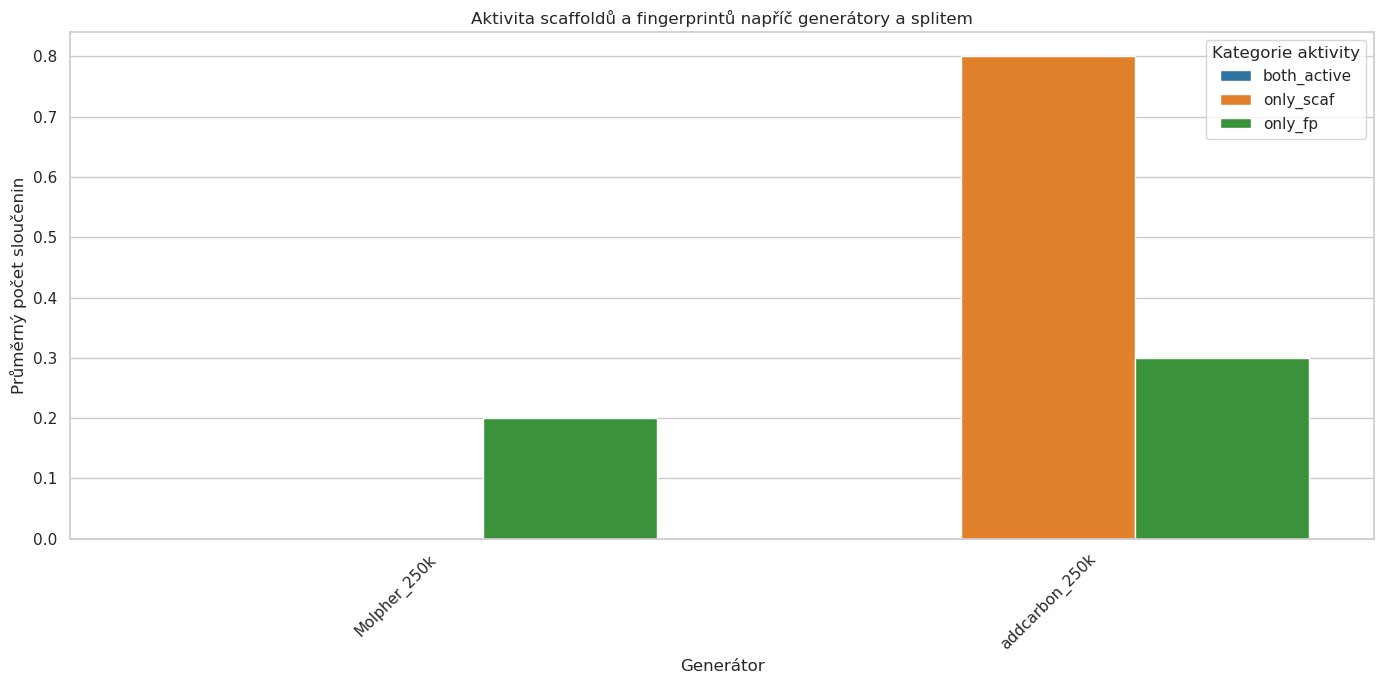

In [70]:

# Převést do long formátu pro seaborn (melt)
plot_df = all_avg_res.melt(id_vars=['generator', 'split'], 
                         value_vars=['both_active', 'only_scaf', 'only_fp'],
                         var_name='activity_category', value_name='count')

# Barevná paleta pro kategorie
palette = {
    'both_active': '#1f77b4',   # modrá
    'only_scaf': '#ff7f0e',     # oranžová
    'only_fp': '#2ca02c',       # zelená   
}

# Vykreslení stacked barplotu
plt.figure(figsize=(14, 7))
sns.set(style="whitegrid")
sns.barplot(
    data=plot_df,
    x='generator',
    y='count',
    hue='activity_category',
    hue_order=['both_active', 'only_scaf', 'only_fp'],
    palette=palette,
    ci=None
)

plt.title("Aktivita scaffoldů a fingerprintů napříč generátory a splitem")
plt.xlabel("Generátor")
plt.ylabel("Průměrný počet sloučenin")
plt.legend(title="Kategorie aktivity")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/var/tmp/pbs.137990.lich-compute.vscht.cz/ipykernel_45029/2800405895.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


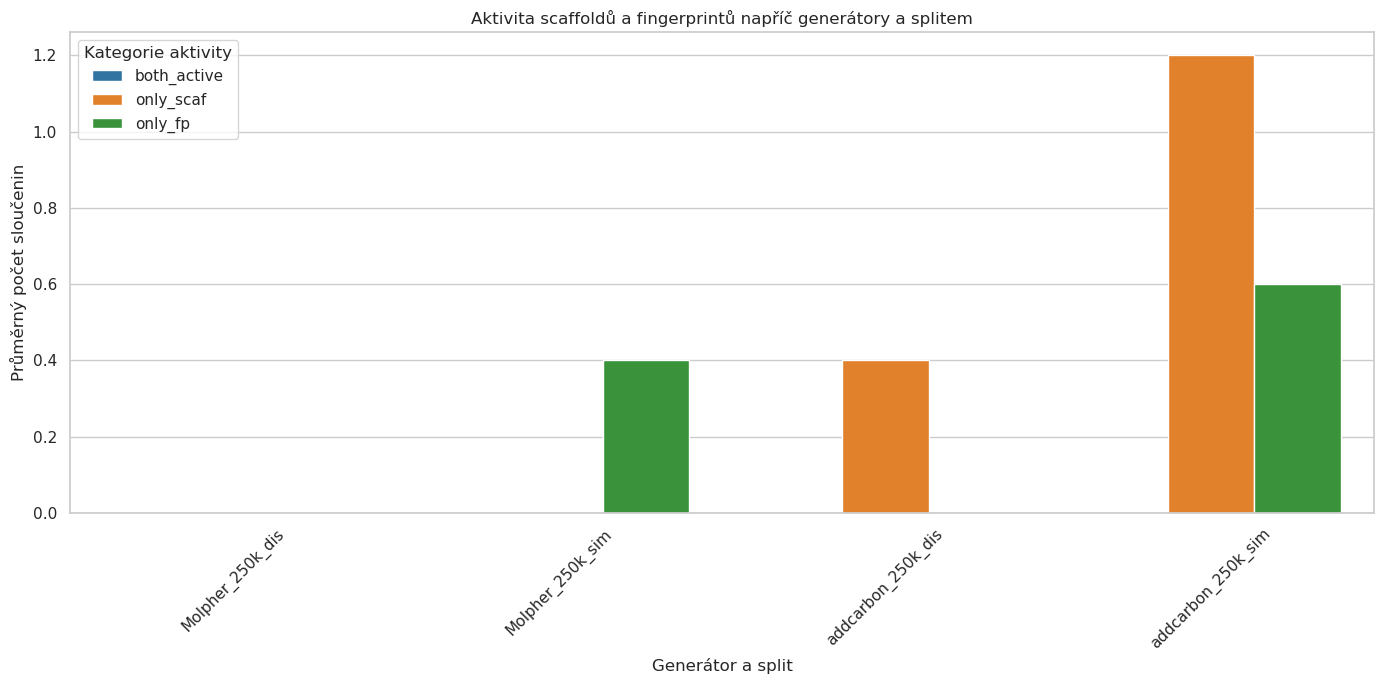

In [73]:
# Přidáme nový sloupec, který spojí 'generator' a 'split'
plot_df['generator_split'] = plot_df['generator'] + "_" + plot_df['split']

plt.figure(figsize=(14, 7))
sns.set(style="whitegrid")
sns.barplot(
    data=plot_df,
    x='generator_split',  # použijeme nově vytvořený sloupec
    y='count',
    hue='activity_category',
    hue_order=['both_active', 'only_scaf', 'only_fp'],
    palette=palette,
    ci=None
)

plt.title("Aktivita scaffoldů a fingerprintů napříč generátory a splitem")
plt.xlabel("Generátor a split")
plt.ylabel("Průměrný počet sloučenin")
plt.legend(title="Kategorie aktivity")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
